# LFADS
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Follow the link below to run in Google Colab or continue if running locally.

Run the first few cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_LFADS.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_LFADS.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [1]:
import os
import sys
from pathlib import Path
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    if sys.version_info > (3, 0):
        from importlib import reload
        !pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-latest-cp36-none-linux_x86_64.whl
    else:
        !pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-latest-cp27-none-linux_x86_64.whl
    !pip install --upgrade -q git+https://github.com/google/jax.git

    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

In [2]:
# Download and unzip data (2.1 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")


Data directory found. Skipping download.


## Get LFADS code from google research repository

In [14]:
if not (Path.cwd() / '..' / 'ctd').is_dir():
    !git clone --recursive https://github.com/google-research/computation-thru-dynamics.git ../ctd
    !mv -R ../ctd/lfads_tutorial ./
import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

## Imports


In [16]:
import jax.numpy as np
from jax import random
from jax.experimental import optimizers
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import time

## Randomization
> JAX uses its own setup to handle randomness and seeding the pseudo-random number generators.
You can read about it [here](https://github.com/google/jax/blob/master/README.md#random-numbers-are-different).


In [5]:
MAX_SEED_INT = 10000000
key = random.PRNGKey(onp.random.randint(0, MAX_SEED_INT))


## Get Data
Unlike notebook 05_02, where we used a small number of wide bins per sequence,
here we use a large number of narrow bins per sequence, where a sequence corresponds to an entire trial
from target onset to target hit (and a bit beyond for short trials).
### Data Hyperparameters


In [6]:
SESS_IDX = 7          # Index of recording session we will use. 0:8
MAX_TRIAL_DUR = 1.7   # This gets rid of about 7% of the slowest trials (long tail distribution)
BIN_DURATION = 0.020  # Width of window used to bin spikes, in seconds
P_TRAIN = 0.8         # Proportion of data used for training.


### Load Spiking Data


In [7]:
from data.utils.fileio import load_joeyo_reaching

def load_dat_with_vel_accel(datadir, sess_idx, x_chunk='mu_spiketimes', trial_dur=1.7):
    BEHAV_CHANS = ['CursorX', 'CursorY']
    sess_names = ['indy_201' + _ for _ in ['60921_01', '60927_04', '60927_06', '60930_02', '60930_05', '61005_06',
                                           '61006_02', '70124_01', '70127_03']]
    X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_names[sess_idx], x_chunk=x_chunk)

    # Determine target onset times that we will keep.
    targ_ch_ix = onp.where(onp.in1d(Y_ax_info['channel_names'], ['TargetX', 'TargetY']))[0]
    b_targ_onset = onp.hstack((True, onp.any(onp.diff(Y[targ_ch_ix]) != 0, axis=0)))
    targ_onset_times = Y_ax_info['timestamps'][b_targ_onset]
    b_short_trials = onp.hstack((onp.diff(targ_onset_times) <= trial_dur, False))
    print("Keeping {} of {} trials ({} %) shorter than {} s.".format(onp.sum(b_short_trials),
                                                                    b_short_trials.size,
                                                                    100 * onp.sum(b_short_trials) / b_short_trials.size,
                                                                    trial_dur))
    targ_onset_times = targ_onset_times[b_short_trials]

    # Slice Y to only keep required behaviour data (cursor position)
    b_keep_y_chans = onp.in1d(Y_ax_info['channel_names'], BEHAV_CHANS)
    Y = Y[b_keep_y_chans, :]
    Y_ax_info['channel_names'] = [_ for _ in Y_ax_info['channel_names'] if _ in BEHAV_CHANS]

    # Calculate discrete derivative and double-derivative to get velocity and acceleration.
    vel = onp.diff(Y, axis=1)
    vel = onp.concatenate((vel[:, 0][:, None], vel),
                         axis=1)  # Assume velocity was constant across the first two samples.
    accel = onp.concatenate(([[0], [0]], np.diff(vel, axis=1)), axis=1)  # Assume accel was 0 in the first sample.
    Y = onp.concatenate((Y, vel, accel), axis=0)
    Y_ax_info['channel_names'] += ['VelX', 'VelY', 'AccX', 'AccY']

    return X, Y, X_ax_info, Y_ax_info, targ_onset_times

X, Y, X_ax_info, Y_ax_info, targ_times = load_dat_with_vel_accel(datadir, SESS_IDX, trial_dur=MAX_TRIAL_DUR)


Keeping 463 of 487 trials (95.07186858316221 %) shorter than 1.7 s.


### Segment Into Trials 


In [8]:
def bin_and_segment_spike_times(X, X_ax_info, targ_onset_times,
                                nearest_bin_dur=0.005, nearest_bin_step_dur=None, trial_dur=1.7):

    # We'll use an integer number of samples per bin: the next highest required to get the requested nearest_bin_dur
    samps_per_bin = int(onp.ceil(nearest_bin_dur * X_ax_info['fs']))
    true_bin_dur = samps_per_bin / X_ax_info['fs']
    print("Actual bin duration: {}".format(true_bin_dur))

    # Similar for number of samples per bin-step.
    if nearest_bin_step_dur is not None:
        samps_per_step = int(onp.ceil(nearest_bin_step_dur * X_ax_info['fs']))
        print("Actual bin duration: {}".format(samps_per_bin / X_ax_info['fs']))
    else:
        # No overlap
        samps_per_step = samps_per_bin

    # Get the indices of each bin-start
    bin_starts_idx = onp.arange(0, X.shape[-1], samps_per_step)
    b_full_bins = bin_starts_idx <= (X.shape[-1] - samps_per_bin)
    bin_starts_idx = bin_starts_idx[b_full_bins]

    # The next chunk of code counts the number of spikes in each bin.
    # -Create array of indices to reslice the raster data
    bin_ix = onp.arange(samps_per_bin)[:, None] + bin_starts_idx[None, :]
    # -Create buffer to hold the dense raster data
    _temp = onp.zeros(X[0].shape, dtype=bool)
    # -Preallocate _X to hold spike counts per bin
    _X = onp.zeros((len(bin_starts_idx), X.shape[0]), dtype=np.int32)
    for chan_ix in range(X.shape[0]):
        _X[:, chan_ix] = np.sum(X[chan_ix].toarray(out=_temp)[0][bin_ix], axis=0)

    # Now that our data are binned, let's slice it up into trials.
    bins_per_trial = int(trial_dur / true_bin_dur)
    trial_X = onp.zeros((len(targ_onset_times), bins_per_trial, _X.shape[-1]))

    bin_stops_t = X_ax_info['timestamps'][bin_starts_idx + samps_per_bin - 1]
    trial_starts_idx = onp.searchsorted(bin_stops_t, targ_onset_times)
    for trial_ix, t_start_idx in enumerate(trial_starts_idx):
        trial_X[trial_ix] = _X[t_start_idx:t_start_idx+bins_per_trial, :]

    in_trial_tvec = onp.arange(bins_per_trial) * true_bin_dur

    return trial_X, in_trial_tvec, true_bin_dur

trial_X, trial_tvec, true_bin_dur = bin_and_segment_spike_times(X, X_ax_info, targ_times,
                                                                nearest_bin_dur=BIN_DURATION, trial_dur=MAX_TRIAL_DUR)

Actual bin duration: 0.02048


### Split Train and Validation


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(trial_X, train_size=P_TRAIN)


### Visualize Data


trial_X has 463 trials, 83 bin-steps per trial, and 91 neurons.


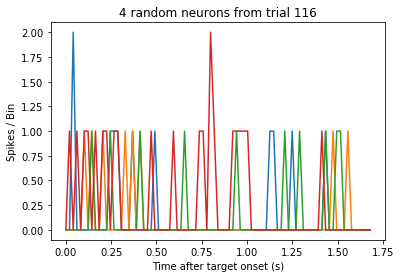

In [10]:
fig = plt.figure(facecolor='white')

n_trials, n_timesteps, n_neurons = trial_X.shape
print("trial_X has {} trials, {} bin-steps per trial, and {} neurons.".format(n_trials, n_timesteps, n_neurons))
trial_idx = onp.random.randint(0, n_trials-1, 1)[0]
neuron_idx = onp.random.randint(0, n_neurons-1, 4)
plt.plot(trial_tvec, trial_X[trial_idx, :, neuron_idx].T)
plt.title("{} random neurons from trial {}".format(len(neuron_idx), trial_idx))
plt.xlabel('Time after target onset (s)')
plt.ylabel('Spikes / Bin')

plt.show()


## LFADS - Latent Factor Analysis via Dynamical Systems
The rest of this notebook is based on a notebook and supporting code found in in the
[google-research/computation-thru-dynamics github repo](https://github.com/google-research/computation-thru-dynamics).

The LFADS model is summarized in the below diagram. For now we will ignore the bottom "Controller" and "Inferred inputs" parts.

![](https://raw.githubusercontent.com/google-research/computation-thru-dynamics/master/images/lfads_architecture_w_inferred_inputs_3.png)

The model is described in commented pseudocode below.

In [14]:
# Our data is of shape n_trials x n_bins_per_trial (aka timesteps) x n_neurons.
# The batched_data is a list of data of shape n_trials_per_batch x n_bins_per_trial x n_neurons
# Here we initialize it with an empty list just so we don't trigger errors when trying to run this cell.
batched_data = []

# For each batch of binned spike counts
for binned_spike_counts in batched_data:
    
    ##################
    ## ENCODER PART ##
    
    # Randomly drop out spikes. Re-randomized for each time-step!
    do_binned_spike_counts = Dropout(binned_spike_counts)
    
    # Run the data through a nonlinear recurrent **encoder**. They use a Bidirectional GRU layer.
    # n_neurons -> 2 * ENC_DIM
    _, enc_ends_fwd_last_bkwd_first = BidirectionalGRU(do_binned_spike_counts)
    # First return value is only used when calculating inferred inputs.
    
    # Convert the end-points of the RNN output to 'initial conditions', which is the per-trial mean and variance
    # to produce random vectors to encode the trial. This is the 'bottleneck' or 'latent variables' in a VAE.
    # 2 * ENC_DIM -> 2 * GEN_DIM; GEN_DIM for means and GEN_DIM for logvars
    ic_mean_logvar = Dense(Dropout(enc_ends_fwd_last_bkwd_first))
    
    ##################
    ## DECODER PART ##
    
    # The initial state used in the next step is a vector randomly drawn from the distribution calculated above.
    g = initial_state = diag_gaussian_sample(ic_mean_logvar)
    
    # The generator is a GRU that takes as input the initial state.
    # In the tensorflow implementation, this was a slightly specialized GRU: https://github.com/tensorflow/models/blob/c80de2ca3ec34c4d510961b6a604309772fc02ad/research/lfads/lfads.py#L158
    # The output is the RNN state timeseries.
    # 2 * GEN_DIM -> timesteps x GEN_DIM
    gen_states = []
    for step_ix in range(n_bins_per_trial):
        g = GRU(g)
        g = Dropout(g)
        gen_states.append(g)
        
    # Normed linear transform the generator states into a time series of latent factors
    latent_factors = NormedLinear(gen_states)
        
    # The factors are transformed to give 'rates' for as many channels as there were neurons in the binned_spike_counts.
    reconstructed_log_rates = Dense(latent_factors)
    reconstructed_rates = exp(reconstructed_log_rates)
    
    ##########
    ## LOSS ##
    
    # The rates parameterize a Poisson distribution from which new spike trains are drawn.
    # And the new spike trains are compared to the input spike trains.
    log_p_xgz = mean(poisson_log_likelihood(binned_spike_counts, reconstructed_rates))
    # Combine with KL loss and L2 regularization.
    loss = -log_p_xgz + kl_loss() + l2_loss()
    
    ############
    ## UPDATE ##
    
    # All of the above would be wrapped in a compiled loss_fn called once per batch,
    # then we can use JAX grad to calculate the gradients of that function.
    gradients = grad(loss_fn)
        
    # Then the optimizer updates the model weights using the gradients.
    optimizer_update(gradients)
    

## LFADS Hyperparameters

In the above pseudocode the dimensions are mentioned but the hyperparameters are omitted.
There are many.

In [11]:
BATCH_SIZE = 4        # Number of trials in each training step during optimization
EPOCHS = 10           # Number of loops through the entire data set.

# LFADS architecture
ENC_DIM = 32          # encoder dim
CON_DIM = 2           # controller dim
II_DIM = 1
GEN_DIM = 32          # generator dim, should be large enough to generate dynamics
FACTORS_DIM = 8       # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
VAR_MIN = 0.001               # Minimal variance any gaussian can become.

# Initial state prior parameters
# the mean is set to zero in the code
IC_PRIOR_VAR = 0.1            # this is sigma^2 of uninformative prior

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

# Optimization Hyperparameters
num_batches = int(n_trials * EPOCHS / BATCH_SIZE)  # how many batches do we train
print_every = 20              # give information every so often

# Learning rate HPs
STEP_SIZE = 0.05              # initial learning rate
DECAY_FACTOR = 0.995          # learning rate decay param
DECAY_STEPS = 1               # learning rate decay param

# Regularization HPs
P_DROPOUT = 0.05              # Proportion of units to set to 0 on each step.
keep_rate = 1 - P_DROPOUT
L2_REG = 2.0e-5               # Parameter regularization strength.

# Numerical stability HPs
MAX_GRAD_NORM = 10.0          # gradient clipping above this value


### KL Warmup
From [LFADS tutorial optimize.py](https://github.com/google-research/computation-thru-dynamics/blob/master/lfads_tutorial/optimize.py):

> It turns out that the KL term can be a lot easier to optimize initially than learning how to
reconstruct your data. This results in a pathological stoppage of training where the KL goes to
nearly zero and training is broken there on out (as you cannot represent any a given trial from
uninformative priors). One way out of this is to warmup the KL penality, starting it off with a
weight term of 0 and then slowly building to 1, giving the reconstruction a chance to train a bit
without the KL penalty messing things up.


In [12]:
kl_warmup_start = 50.0 # batch number to start kl warmup, explicitly float
kl_warmup_end = 250.0  # batch number to be finished with kl warmup, explicitly float
kl_min = 0.01 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.0


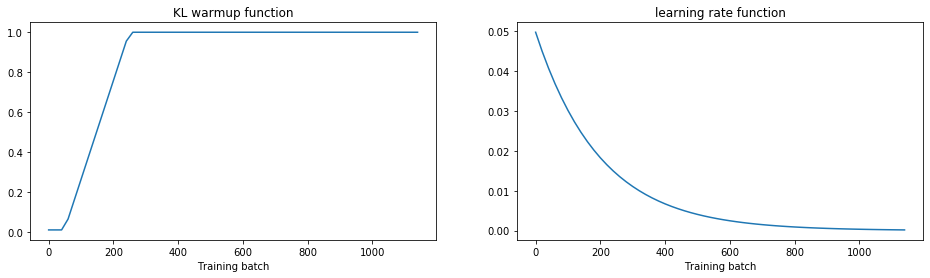

In [17]:
# Plot the warmup function and the learning rate decay function.
plt.figure(figsize=(16,4), facecolor='white')
plt.subplot(1, 2, 1)
x = onp.arange(0, num_batches, print_every)
kl_params = {'kl_warmup_start': kl_warmup_start,
             'kl_warmup_end': kl_warmup_end,
             'kl_min': kl_min,
             'kl_max': kl_max}
kl_warmup_fun = get_kl_warmup_fun(kl_params)
plt.plot(x, [kl_warmup_fun(i) for i in onp.arange(1, num_batches, print_every)]);
plt.title('KL warmup function')
plt.xlabel('Training batch')

plt.subplot(1, 2, 2)
decay_fun = optimizers.exponential_decay(STEP_SIZE, DECAY_STEPS, DECAY_FACTOR)
plt.plot(x, [decay_fun(i) for i in range(1, num_batches, print_every)])
plt.title('learning rate function')
plt.xlabel('Training batch') 

plt.show()

### Collect hyperparams


In [18]:
lfads_hps = {'data_dim' : n_neurons, 'ntimesteps' : n_timesteps,
             'enc_dim' : ENC_DIM, 'con_dim' : CON_DIM, 'var_min' : VAR_MIN,
             'ic_prior_var' : IC_PRIOR_VAR, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : II_DIM, 'gen_dim' : GEN_DIM,
             'factors_dim' : FACTORS_DIM,
             'l2reg' : L2_REG,
             'batch_size' : BATCH_SIZE}

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : STEP_SIZE,
                 'decay_steps' : DECAY_STEPS, 'decay_factor' : DECAY_FACTOR,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : MAX_GRAD_NORM, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-1}

init_params = lfads.lfads_params(key, lfads_hps)


## Train LFADS


In [ ]:
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps, X_train, X_valid)


### Plot training details


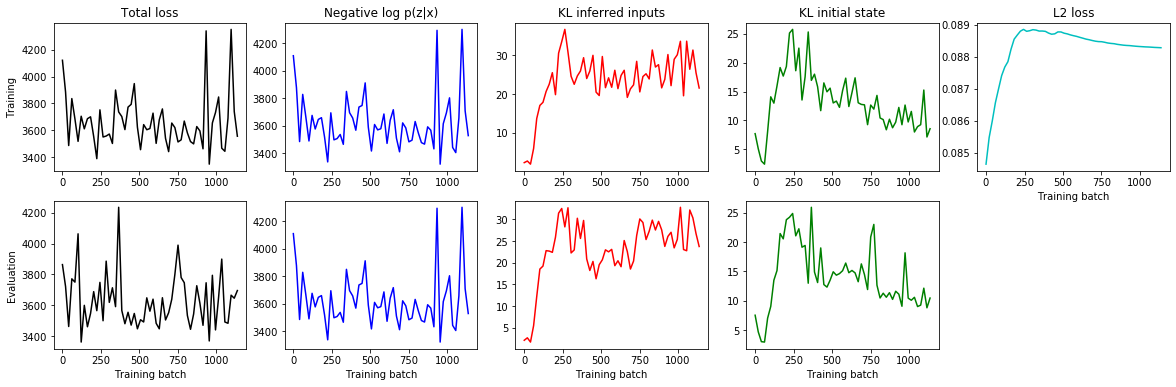

In [41]:
# Plot the training details
# x = onp.arange(0, num_batches, print_every)
x = onp.arange(len(opt_details['tlosses']['total'])) * num_batches / len(opt_details['tlosses']['total'])
plt.figure(figsize=(20,6), facecolor='white')
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');


In [ ]:
#%%
# See the effect of the KL warmup, which is shown 
# by the KL penalities without the warmup scaling. 
plt.figure(figsize=(7,4))
plt.subplot(221)
plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Training')
plt.subplot(222)
plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
plt.subplot(223)
plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Evaluation')
plt.xlabel('Training batch')
plt.subplot(224)
plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
plt.xlabel('Trainign batch')


### Save the result


In [ ]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                 fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

# Note we are just using numpy save instead of h5 because the LFADS parameter 
# is nested dictionaries, something I couldn't get h5 to save down easily.
print("Saving parameters: ", network_path)
onp.savez(network_path, trained_params)


## Inspect Model